### Prerequisites

* Choose `Switch instance type` above
* Toggle `Fast launch only` to select more instance types
* Change instance type to `ml.m5.2xlarge`
* For Kernel, choose `Python 3 (Data Science)`

##### > Install dependencies 

In [ ]:
%%capture 

!pip install sagemaker==2.100.0
!pip install sklearn==0.22.1
!pip install boto3==1.24.12
!pip install kaggle==1.5.12
!pip install pandas==1.0.1

**Note:** Recommended to restart the Kernel after installing the dependencies above

### Imports 

In [27]:
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image
from sagemaker import Session
from pandas import DataFrame
from time import sleep
import pandas as pd
import sagemaker
import sklearn
import logging
import pickle
import boto3
import os

##### > Setup logging

In [2]:
logger = logging.getLogger('sagemaker')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

##### > Log versions of dependencies

In [3]:
logger.info(f'[Using SageMaker version: {sagemaker.__version__}]')
logger.info(f'[Using Sklearn version: {sklearn.__version__}]')
logger.info(f'[Using Boto3 version: {boto3.__version__}]')
logger.info(f'[Using Pandas version: {pd.__version__}]')

[Using SageMaker version: 2.100.0]
[Using Sklearn version: 0.22.1]
[Using Boto3 version: 1.24.12]
[Using Pandas version: 1.0.1]


### Essentials

In [4]:
session = Session()
s3 = boto3.resource('s3')

S3_BUCKET = session.default_bucket()
S3_DATA_FOLDER = 'data'

logger.info(f'S3 bucket = {S3_BUCKET}')

S3 bucket = sagemaker-us-east-1-119174016168


### Prepare data

##### > Follow the instructions below to download COVID news articles dataset from kaggle here: https://www.kaggle.com/datasets/timmayer/covid-news-articles-2020-2022/

* Create a Kaggle account if you don't have one using an email id.
* Once you have an account, under Account, click `Create New API Token` button as shown below.
* This should download a JSON file named `kaggle.json` with your API credentials.
* Copy the `username` and `key` from the downloaded JSON and assign it to the environment variables as shown below.

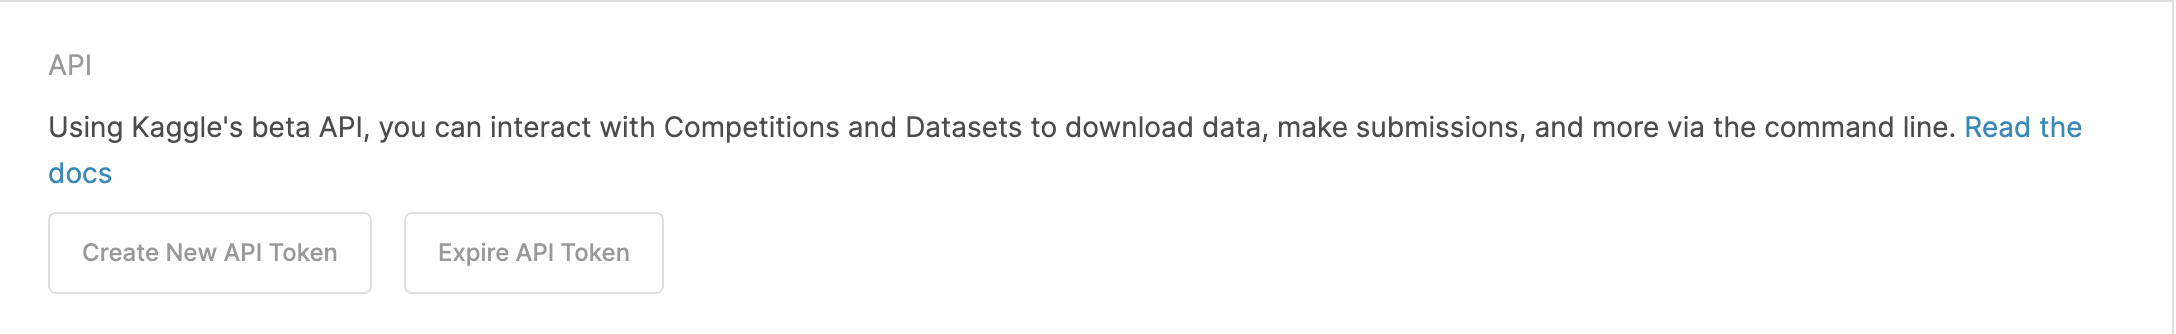

In [28]:
Image(filename='./../img/kaggle-credentials.png')

In [5]:
os.environ['KAGGLE_USERNAME'] = 'XXXXXXX'
os.environ['KAGGLE_KEY'] = 'XXXXXXX'

##### > Download raw dataset from Kaggle to your local directory

In [6]:
!kaggle datasets download -d timmayer/covid-news-articles-2020-2022 
!unzip covid-news-articles-2020-2022.zip

 99%|████████████████████████████████████████▌| 878M/889M [00:04<00:00, 193MB/s]
100%|████████████████████████████████████████| 889M/889M [00:11<00:00, 81.1MB/s]
Archive:  covid-news-articles-2020-2022.zip
  inflating: covid_articles_raw.csv  


##### > Upload raw dataset from local to S3

In [7]:
!aws s3 cp covid_articles_raw.csv s3://{S3_BUCKET}/data/covid_articles_raw.csv 

upload: ./covid_articles_raw.csv to s3://sagemaker-us-east-1-119174016168/data/covid_articles_raw.csv


In [8]:
RAW_INPUT_DATA_S3_LOCATION = f's3://{S3_BUCKET}/data/covid_articles_raw.csv'

##### > Read raw dataset into a pandas dataframe

In [9]:
%%time

df = pd.read_csv(RAW_INPUT_DATA_S3_LOCATION)
df.dropna(inplace=True)

CPU times: user 30.8 s, sys: 8.05 s, total: 38.8 s
Wall time: 57.7 s


In [10]:
df.head()

,title,content,category
0,Looking into the truth about modern workplace ...,"Hi, what are you looking for?\nBy\nPublished\n...",general
1,Hexo refiles financial statements,"New York reported a record 90,132 new Covid-19...",general
2,"Japan raid, Turkey arrests in widening Ghosn p...","Hi, what are you looking for?\nBy\nPublished\n...",general
3,Pope's bodyguards criticised over slapping inc...,"Hi, what are you looking for?\nBy\nPublished\n...",general
4,Lebanon denies president welcomed fugitive Ghosn,"Hi, what are you looking for?\nBy\nPublished\n...",general


In [11]:
df.shape

(477536, 3)

### III. Prepare dataset for BERT MLM training 

In [12]:
mlm_df = df[['title', 'content']]
mlm_df.head()

,title,content
0,Looking into the truth about modern workplace ...,"Hi, what are you looking for?\nBy\nPublished\n..."
1,Hexo refiles financial statements,"New York reported a record 90,132 new Covid-19..."
2,"Japan raid, Turkey arrests in widening Ghosn p...","Hi, what are you looking for?\nBy\nPublished\n..."
3,Pope's bodyguards criticised over slapping inc...,"Hi, what are you looking for?\nBy\nPublished\n..."
4,Lebanon denies president welcomed fugitive Ghosn,"Hi, what are you looking for?\nBy\nPublished\n..."


In [13]:
with open('.././data/covid_articles.txt', 'w', encoding='utf-8') as f:
    for title, content in zip(mlm_df.title.values, mlm_df.content.values):
        f.write('\n'.join([title, content]))

##### Copy dataset from local to S3

In [14]:
%%time

s3.meta.client.upload_file('.././data/covid_articles.txt', S3_BUCKET, f'{S3_DATA_FOLDER}/covid_articles.txt')

CPU times: user 16.5 s, sys: 15.1 s, total: 31.6 s
Wall time: 12.5 s


### IV. Prepare dataset for sequence classification 

In [15]:
clf_df = df.copy()

In [16]:
clf_df.drop(['content'], axis=1, inplace=True) 

In [17]:
set(clf_df.category.unique())

{'business', 'esg', 'general', 'science', 'tech'}

##### Label encode `category` column

In [18]:
label_encoder = LabelEncoder()
clf_df['category'] = label_encoder.fit_transform(clf_df['category'])

##### Get label mapping

In [19]:
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_map = dict((k, str(v)) for k, v in label_map.items())
label_map

{'business': '0', 'esg': '1', 'general': '2', 'science': '3', 'tech': '4'}

##### Save label mapping to be used during inference

In [20]:
with open('.././data/label_map', 'wb') as f:
     pickle.dump(label_map, f, protocol=pickle.HIGHEST_PROTOCOL)

##### Copy dataset from local to S3 

In [21]:
%%time 

clf_df.to_csv('.././data/covid_articles_clf_data.csv',  encoding='utf-8', index=False, header=False)

CPU times: user 975 ms, sys: 3.59 ms, total: 978 ms
Wall time: 1.13 s


In [22]:
%%time 

s3.meta.client.upload_file('.././data/covid_articles_clf_data.csv', S3_BUCKET, f'{S3_DATA_FOLDER}/covid_articles_clf_data.csv')

CPU times: user 194 ms, sys: 156 ms, total: 350 ms
Wall time: 487 ms


#### Clean up local copies of data 

In [23]:
! rm covid_articles_raw.csv

In [24]:
! rm covid-news-articles-2020-2022.zip

In [25]:
! rm .././data/covid_articles.txt

In [26]:
! rm .././data/covid_articles_clf_data.csv